#Install Libraries

In [2]:
%pip install transformers

In [1]:
# Config

k = 4. # number of digits - 1000 to 9999
num_samples = 75000

frac_train = 0.6
frac_val = 0.2

#Define Task

*   Define input and output ("a + b =" and "c")



In [2]:
import random

def generate_dataset(num_samples):

    dataset = set()

    while len(dataset) < num_samples:
      a = random.randint(1000, 9999)
      b = random.randint(1000, 9999)

      c = a + b  #Addition

      input_str = f"{a} + {b} ="
      output_str = str(c)

      dataset.add((input_str, output_str))

    return list(dataset)

dataset = generate_dataset(num_samples)
print(f"Length of dataset: {len(dataset)}")

Length of dataset: 75000


In [3]:
# Train, val, test split
random.shuffle(dataset)

train_end = int(num_samples * frac_train)
val_end = train_end + int(num_samples * frac_val)

train_data = dataset[:train_end]
val_data = dataset[train_end:val_end]
test_data = dataset[val_end:]

print(len(train_data))
print(len(val_data))
print(len(test_data))

45000
15000
15000


In [4]:
print(train_data[:5])

[('4113 + 3092 =', '7205'), ('7051 + 7153 =', '14204'), ('2538 + 6880 =', '9418'), ('4483 + 2037 =', '6520'), ('5896 + 8526 =', '14422')]


#Training


*   Character Tokenizer
*   Transformer Model
*   Training Functions



In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
# tokenizer
class CharacterTokenizer:
    """Character-level tokenizer for addition"""

    def __init__(self):
        self.chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '+', '=']
        self.PAD_TOKEN = '<PAD>'

        self.vocab = [self.PAD_TOKEN] + self.chars
        self.char_to_idx = {char: idx for idx, char in enumerate(self.vocab)}
        self.idx_to_char = {idx: char for idx, char in enumerate(self.vocab)}

        self.vocab_size = len(self.vocab)
        self.pad_idx = self.char_to_idx[self.PAD_TOKEN]

    def encode(self, text):
        """Convert text to token indices"""
        return [self.char_to_idx[char] for char in text]

    def decode(self, indices):
        """Convert token indices back to text"""
        chars = [self.idx_to_char[idx] for idx in indices
                 if idx != self.pad_idx]
        return ''.join(chars)

# Dataset preparation - convert to tokens
class AdditionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=32, ignore_index=-100):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.ignore_index = ignore_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_str, output_str = self.data[idx]

        full_sequence = input_str + " " + output_str  # "2506 + 7036 = 9542"
        prompt = input_str + " "                       # "2506 + 7036 = "

        full_tokens = self.tokenizer.encode(full_sequence)
        prompt_len = len(self.tokenizer.encode(prompt))

        # Pad if needed
        if len(full_tokens) < self.max_length:
            full_tokens = full_tokens + [self.tokenizer.pad_idx] * (self.max_length - len(full_tokens))
        else:
            full_tokens = full_tokens[:self.max_length]

        # Shift for autoregressive
        input_ids = torch.tensor(full_tokens[:-1], dtype=torch.long)
        labels = torch.tensor(full_tokens[1:], dtype=torch.long)

        # Mask prompt portion
        # In labels, the prompt occupies positions 0 to (prompt_len - 2) because of the shift
        labels[:prompt_len - 1] = self.ignore_index

        # Mask padding
        labels[labels == self.tokenizer.pad_idx] = self.ignore_index

        return input_ids, labels

In [13]:
# Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=6,
                 dim_feedforward=512, dropout=0.1, max_len=512):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        src = self.dropout(src)

        output = self.transformer(src, src_key_padding_mask=src_mask)
        output = self.fc_out(output)

        return output


In [23]:
# Training Functions
def train_epoch(model, train_loader, optimizer, criterion, device, grad_clip=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    total_correct_seqs = 0
    total_seqs = 0

    for batch_idx, (input_ids, target_ids) in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()

        # Character accuracy
        predictions = logits.argmax(dim=-1)
        mask = target_ids != -100
        correct = (predictions == target_ids) & mask
        total_correct_chars += correct.sum().item()
        total_chars += mask.sum().item()

        # Sequence accuracy
        for pred_seq, label_seq in zip(predictions, target_ids):
            output_mask = label_seq != -100
            if output_mask.sum() > 0:
                if torch.equal(pred_seq[output_mask], label_seq[output_mask]):
                    total_correct_seqs += 1
                total_seqs += 1

    avg_loss = total_loss / len(train_loader)
    char_accuracy = total_correct_chars / total_chars
    seq_accuracy = total_correct_seqs / total_seqs if total_seqs > 0 else 0.0

    return avg_loss, char_accuracy, seq_accuracy


def evaluate(model, val_loader, criterion, tokenizer, device):
    """Evaluate on validation/test set"""
    model.eval()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    total_correct_sequences = 0
    total_sequences = 0

    with torch.no_grad():
        for input_ids, labels in tqdm(val_loader, desc="Evaluating"):
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)

            loss = criterion(
                logits.view(-1, logits.size(-1)),
                labels.view(-1)
            )
            total_loss += loss.item()

            predictions = logits.argmax(dim=-1)

            # Character accuracy (only on non-masked tokens(output))
            mask = labels != criterion.ignore_index
            correct_chars = (predictions == labels) & mask
            total_correct_chars += correct_chars.sum().item()
            total_chars += mask.sum().item()

            # Sequence accuracy
            for pred_seq, label_seq in zip(predictions, labels):
                # Extract only output tokens (non-masked)
                output_mask = label_seq != criterion.ignore_index
                pred_output = pred_seq[output_mask]
                label_output = label_seq[output_mask]

                if torch.equal(pred_output, label_output):
                    total_correct_sequences += 1
                total_sequences += 1

    avg_loss = total_loss / len(val_loader)
    char_accuracy = total_correct_chars / total_chars
    seq_accuracy = total_correct_sequences / total_sequences

    return avg_loss, char_accuracy, seq_accuracy


In [39]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion,
                tokenizer, device, num_epochs, save_path='best_model.pt'):
    """Main training loop with early stopping"""

    best_train_seq_acc = 0.0

    history = {
        'train_loss': [],
        'train_seq_acc': []
    }

    for epoch in range(num_epochs):
        print(f"EPOCH {epoch + 1}/{num_epochs}")

        # Training
        train_loss, train_char_acc, train_seq_acc = train_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # Validation
        val_loss, val_char_acc, val_seq_acc = evaluate(
            model, val_loader, criterion, tokenizer, device
        )

        history['train_loss'].append(train_loss)
        history['train_seq_acc'].append(train_seq_acc)

        # Print metrics
        print(f"Train: Loss={train_loss:.4f}, SeqAcc={train_seq_acc:.4f}")
        print(f"Val:   Loss={val_loss:.4f}, SeqAcc={val_seq_acc:.4f}")

        # Save
        if train_seq_acc >= best_train_seq_acc and val_seq_acc >= 0.99:
            best_train_seq_acc = train_seq_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'train_seq_acc': train_seq_acc,
                'val_seq_acc': val_seq_acc,
            }, save_path)
            print(f"Saved (TrainSeqAcc: {train_seq_acc:.4f})")

        # Stop if train is perfect
        if train_seq_acc >= 1.0:
            print(f"Reached 100% training accuracy at epoch {epoch+1}!")
            break

    # Load best model
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n model saved at: TrainSeq={checkpoint['train_seq_acc']:.4f}, ValSeq={checkpoint['val_seq_acc']:.4f}")

    return history

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize tokenizer
tokenizer = CharacterTokenizer()
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Create datasets
train_dataset = AdditionDataset(train_data, tokenizer, max_length=32)
val_dataset = AdditionDataset(val_data, tokenizer, max_length=32)
test_dataset = AdditionDataset(test_data, tokenizer, max_length=32)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model
model = TransformerModel(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    nhead=4,
    num_layers=6,
    dim_feedforward=512,
    dropout=0.1,
    max_len=32
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
def lr_lambda(step):
    warmup_steps = 1000
    if step < warmup_steps:
        return step / warmup_steps
    return 0.5 ** ((step - warmup_steps) / 5000)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Train!
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    tokenizer=tokenizer,
    device=device,
    num_epochs=30,
    save_path='best_model.pt'
)

Using device: cuda
Vocabulary size: 14
Total parameters: 1,193,230
EPOCH 1/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 30.75it/s]


Train: Loss=0.9396, SeqAcc=0.4935
Val:   Loss=0.0025, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.4935)
EPOCH 2/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.73it/s]


Train: Loss=0.0095, SeqAcc=0.9927
Val:   Loss=0.0007, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9927)
EPOCH 3/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.90it/s]


Train: Loss=0.0088, SeqAcc=0.9913
Val:   Loss=0.0011, SeqAcc=0.9983
EPOCH 4/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.64it/s]


Train: Loss=0.0060, SeqAcc=0.9939
Val:   Loss=0.0002, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9939)
EPOCH 5/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.28it/s]


Train: Loss=0.0022, SeqAcc=0.9981
Val:   Loss=0.0001, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9981)
EPOCH 6/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.38it/s]


Train: Loss=0.0031, SeqAcc=0.9970
Val:   Loss=0.0003, SeqAcc=0.9997
EPOCH 7/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.37it/s]


Train: Loss=0.0033, SeqAcc=0.9971
Val:   Loss=0.0001, SeqAcc=1.0000
EPOCH 8/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.46it/s]


Train: Loss=0.0038, SeqAcc=0.9962
Val:   Loss=0.0001, SeqAcc=1.0000
EPOCH 9/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 33.53it/s]


Train: Loss=0.0021, SeqAcc=0.9982
Val:   Loss=0.0001, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9982)
EPOCH 10/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.21it/s]


Train: Loss=0.0032, SeqAcc=0.9972
Val:   Loss=0.0001, SeqAcc=1.0000
EPOCH 11/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.58it/s]


Train: Loss=0.0015, SeqAcc=0.9984
Val:   Loss=0.0001, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9984)
EPOCH 12/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.82it/s]


Train: Loss=0.0018, SeqAcc=0.9987
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9987)
EPOCH 13/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.81it/s]


Train: Loss=0.0014, SeqAcc=0.9988
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9988)
EPOCH 14/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.73it/s]


Train: Loss=0.0022, SeqAcc=0.9980
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 15/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 29.31it/s]


Train: Loss=0.0010, SeqAcc=0.9992
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9992)
EPOCH 16/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 27.80it/s]


Train: Loss=0.0009, SeqAcc=0.9995
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9995)
EPOCH 17/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.39it/s]


Train: Loss=0.0019, SeqAcc=0.9986
Val:   Loss=0.0001, SeqAcc=1.0000
EPOCH 18/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 32.80it/s]


Train: Loss=0.0014, SeqAcc=0.9989
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 19/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.41it/s]


Train: Loss=0.0007, SeqAcc=0.9996
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9996)
EPOCH 20/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.24it/s]


Train: Loss=0.0010, SeqAcc=0.9994
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 21/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.63it/s]


Train: Loss=0.0004, SeqAcc=0.9997
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9997)
EPOCH 22/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.88it/s]


Train: Loss=0.0008, SeqAcc=0.9994
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 23/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.94it/s]


Train: Loss=0.0023, SeqAcc=0.9982
Val:   Loss=0.0001, SeqAcc=1.0000
EPOCH 24/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 30.55it/s]


Train: Loss=0.0004, SeqAcc=0.9997
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9997)
EPOCH 25/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.22it/s]


Train: Loss=0.0002, SeqAcc=0.9999
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9999)
EPOCH 26/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.40it/s]


Train: Loss=0.0004, SeqAcc=0.9996
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 27/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 31.32it/s]


Train: Loss=0.0004, SeqAcc=0.9997
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 28/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 33.72it/s]


Train: Loss=0.0002, SeqAcc=0.9999
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9999)
EPOCH 29/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.61it/s]


Train: Loss=0.0006, SeqAcc=0.9995
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 30/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 34.24it/s]


Train: Loss=0.0005, SeqAcc=0.9996
Val:   Loss=0.0000, SeqAcc=1.0000

 model saved at: TrainSeq=0.9999, ValSeq=1.0000


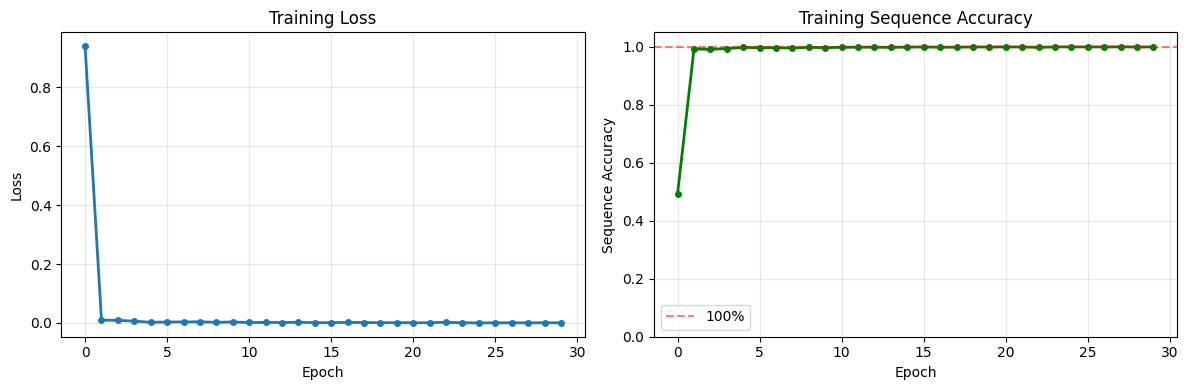

In [42]:
import matplotlib.pyplot as plt

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training Loss
ax1.plot(history['train_loss'], marker='o', linewidth=2, markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Plot 2: Training Sequence Accuracy
ax2.plot(history['train_seq_acc'], marker='o', linewidth=2, markersize=4, color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sequence Accuracy')
ax2.set_title('Training Sequence Accuracy')
ax2.set_ylim([0, 1.05])
ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='100%')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [43]:
def print_sample_predictions(model, dataset, tokenizer, device, num_samples=5):
    """Print sample predictions to see how model is doing"""
    model.eval()
    print("SAMPLE PREDICTIONS")

    indices = torch.randperm(len(dataset))[:num_samples]

    with torch.no_grad():
        for idx in indices:
            input_ids, target_ids = dataset[idx]
            input_ids_tensor = input_ids.unsqueeze(0).to(device)

            logits = model(input_ids_tensor)
            predictions = logits.argmax(dim=-1).squeeze(0)

            # Create mask for non-ignored tokens
            mask = target_ids != -100

            # Get the actual original data to show the prompt
            original_input, original_output = dataset.data[idx]

            # Extract target tokens (only non-masked positions)
            target_tokens = target_ids[mask].cpu().tolist()

            # Extract predicted tokens (same positions)
            pred_tokens = predictions[mask].cpu().tolist()

            # Decode
            target_text = tokenizer.decode(target_tokens)
            pred_text = tokenizer.decode(pred_tokens)

            # Display
            print(f"Problem:     {original_input}")
            print(f"Expected:    {original_output}")
            print(f"Target:      {target_text}")
            print(f"Predicted:   {pred_text}")

In [44]:
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("IN-DISTRIBUTION TEST SET EVALUATION")

test_dataset = AdditionDataset(test_data, tokenizer, max_length=32)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# Evaluate on test set
test_loss, test_char_acc, test_seq_acc = evaluate(
    model, test_loader, criterion, tokenizer, device
)
print(len(test_loader))
print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Character Accuracy: {test_char_acc:.4f}")
print(f"  Sequence Accuracy: {test_seq_acc:.4f}")

print_sample_predictions(model, test_dataset, tokenizer, device, num_samples=3)

IN-DISTRIBUTION TEST SET EVALUATION


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 33.05it/s]

118

Test Results:
  Loss: 0.0000
  Character Accuracy: 1.0000
  Sequence Accuracy: 1.0000
SAMPLE PREDICTIONS
Problem:     3145 + 3765 =
Expected:    6910
Target:      6910
Predicted:   6910
Problem:     9994 + 3202 =
Expected:    13196
Target:      13196
Predicted:   13196
Problem:     9620 + 4787 =
Expected:    14407
Target:      14407
Predicted:   14407


In [45]:
def generate_length_generalization_data(k, num_samples=1000):
    """Generate k-digit addition problems"""
    data = []
    min_val = 10 ** (k - 1)
    max_val = 10 ** k - 1

    for _ in range(num_samples):
        a = random.randint(min_val, max_val)
        b = random.randint(min_val, max_val)
        c = a + b
        input_str = f"{a} + {b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

# Test on 5-digit numbers (k+1)
print("LENGTH GENERALIZATION: 5-DIGIT NUMBERS (k+1)")

k5_data = generate_length_generalization_data(k=5, num_samples=1000)
k5_dataset = AdditionDataset(k5_data, tokenizer, max_length=32)
k5_loader = DataLoader(k5_dataset, batch_size=128, shuffle=False)

k5_loss, k5_char_acc, k5_seq_acc = evaluate(
    model, k5_loader, criterion, tokenizer, device
)

print(f"\n5-Digit Results:")
print(f"  Loss: {k5_loss:.4f}")
print(f"  Character Accuracy: {k5_char_acc:.4f}")
print(f"  Sequence Accuracy: {k5_seq_acc:.4f}")

print_sample_predictions(model, k5_dataset, tokenizer, device, num_samples=3)

# Test on 6-digit numbers (k+2)
print("LENGTH GENERALIZATION: 6-DIGIT NUMBERS (k+2)")

k6_data = generate_length_generalization_data(k=6, num_samples=1000)
k6_dataset = AdditionDataset(k6_data, tokenizer, max_length=32)
k6_loader = DataLoader(k6_dataset, batch_size=128, shuffle=False)

k6_loss, k6_char_acc, k6_seq_acc = evaluate(
    model, k6_loader, criterion, tokenizer, device
)

print(f"\n6-Digit Results:")
print(f"  Loss: {k6_loss:.4f}")
print(f"  Character Accuracy: {k6_char_acc:.4f}")
print(f"  Sequence Accuracy: {k6_seq_acc:.4f}")

print_sample_predictions(model, k6_dataset, tokenizer, device, num_samples=3)

LENGTH GENERALIZATION: 5-DIGIT NUMBERS (k+1)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 24.09it/s]



5-Digit Results:
  Loss: 4.3657
  Character Accuracy: 0.5615
  Sequence Accuracy: 0.0090
SAMPLE PREDICTIONS
Problem:     53604 + 85080 =
Expected:    138684
Target:      138684
Predicted:   038884
Problem:     72223 + 57205 =
Expected:    129428
Target:      129428
Predicted:   224888
Problem:     28291 + 55639 =
Expected:    83930
Target:      83930
Predicted:   33900
LENGTH GENERALIZATION: 6-DIGIT NUMBERS (k+2)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


6-Digit Results:
  Loss: 7.7325
  Character Accuracy: 0.2124
  Sequence Accuracy: 0.0000
SAMPLE PREDICTIONS
Problem:     140366 + 539800 =
Expected:    680166
Target:      680166
Predicted:   080000
Problem:     105360 + 694902 =
Expected:    800262
Target:      800262
Predicted:   002222
Problem:     262996 + 628247 =
Expected:    891243
Target:      891243
Predicted:   494447


In [98]:
# I just checked if 4-digit addition is working if first digit is 0 -> learnt well
def generate_length_generalization_data(k, num_samples=1000):
    """Generate k-digit addition problems"""
    data = []
    min_val = 10 ** (k - 1)
    max_val = 10 ** k - 1

    for _ in range(num_samples):
        a = random.randint(min_val, max_val)
        b = random.randint(min_val, max_val)
        c = a + b
        input_str = f"0{a} + 0{b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

In [46]:
k3_data = generate_length_generalization_data(k=3, num_samples=700)
print(k3_data[0])
k3_dataset = AdditionDataset(k3_data, tokenizer, max_length=32)
k3_loader = DataLoader(k3_dataset, batch_size=128, shuffle=False)

k3_loss, k3_char_acc, k3_seq_acc = evaluate(
    model, k3_loader, criterion, tokenizer, device
)

print(f"\n3-Digit Results:")
print(f"  Loss: {k3_loss:.4f}")
print(f"  Character Accuracy: {k3_char_acc:.4f}")
print(f"  Sequence Accuracy: {k3_seq_acc:.4f}")

print_sample_predictions(model, k3_dataset, tokenizer, device, num_samples=5)

('320 + 734 =', '1054')


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 31.82it/s]


3-Digit Results:
  Loss: 8.3568
  Character Accuracy: 0.3783
  Sequence Accuracy: 0.0057
SAMPLE PREDICTIONS
Problem:     279 + 680 =
Expected:    959
Target:      959
Predicted:   599
Problem:     336 + 252 =
Expected:    588
Target:      588
Predicted:   888
Problem:     940 + 659 =
Expected:    1599
Target:      1599
Predicted:   5999


Problem:     170 + 250 =
Expected:    420
Target:      420
Predicted:   200
Problem:     716 + 398 =
Expected:    1114
Target:      1114
Predicted:   1444


In [30]:
def generate_hard_carry_data(num_samples=1000):
    """Generate additions with many 9s (difficult carries)"""
    data = []

    for _ in range(num_samples):
        # Generate numbers with high probability of 9s
        a_digits = [random.choice([9, 9, 9, random.randint(0, 9)]) for _ in range(4)]
        b_digits = [random.choice([9, 9, 9, random.randint(0, 9)]) for _ in range(4)]

        a = int(''.join(map(str, a_digits)))
        b = int(''.join(map(str, b_digits)))

        # Ensure 4 digits
        if a < 1000:
            a += 1000
        if b < 1000:
            b += 1000

        c = a + b
        input_str = f"{a} + {b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

print("\n" + "="*80)
print("DISTRIBUTION SHIFT: MANY 9s (HARD CARRIES)")
print("="*80)

hard_carry_data = generate_hard_carry_data(num_samples=1000)
hard_carry_dataset = AdditionDataset(hard_carry_data, tokenizer, max_length=32)
hard_carry_loader = DataLoader(hard_carry_dataset, batch_size=128, shuffle=False)

hc_loss, hc_char_acc, hc_seq_acc = evaluate(
    model, hard_carry_loader, criterion, tokenizer, device
)

print(f"\nHard Carry Results:")
print(f"  Loss: {hc_loss:.4f}")
print(f"  Character Accuracy: {hc_char_acc:.4f}")
print(f"  Sequence Accuracy: {hc_seq_acc:.4f}")

print_sample_predictions(model, hard_carry_dataset, tokenizer, device, num_samples=5)


DISTRIBUTION SHIFT: MANY 9s (HARD CARRIES)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.13it/s]


Hard Carry Results:
  Loss: 0.0000
  Character Accuracy: 1.0000
  Sequence Accuracy: 1.0000
SAMPLE PREDICTIONS
Problem:     9949 + 9999 =
Expected:    19948
Target:      19948
Predicted:   19948
Problem:     9999 + 9598 =
Expected:    19597
Target:      19597
Predicted:   19597
Problem:     9199 + 9999 =
Expected:    19198
Target:      19198
Predicted:   19198
Problem:     9997 + 6935 =
Expected:    16932
Target:      16932
Predicted:   16932
Problem:     9998 + 9395 =
Expected:    19393
Target:      19393
Predicted:   19393


In [31]:
def generate_small_numbers_data(num_samples=1000):
    """Generate additions with small numbers (1000-3000)"""
    data = []

    for _ in range(num_samples):
        a = random.randint(1000, 3000)
        b = random.randint(1000, 3000)
        c = a + b
        input_str = f"{a} + {b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

print("\n" + "="*80)
print("DISTRIBUTION SHIFT: SMALL NUMBERS ONLY (1000-3000)")
print("="*80)

small_data = generate_small_numbers_data(num_samples=1000)
small_dataset = AdditionDataset(small_data, tokenizer, max_length=32)
small_loader = DataLoader(small_dataset, batch_size=128, shuffle=False)

small_loss, small_char_acc, small_seq_acc = evaluate(
    model, small_loader, criterion, tokenizer, device
)

print(f"\nSmall Numbers Results:")
print(f"  Loss: {small_loss:.4f}")
print(f"  Character Accuracy: {small_char_acc:.4f}")
print(f"  Sequence Accuracy: {small_seq_acc:.4f}")

print_sample_predictions(model, small_dataset, tokenizer, device, num_samples=5)


DISTRIBUTION SHIFT: SMALL NUMBERS ONLY (1000-3000)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.80it/s]


Small Numbers Results:
  Loss: 0.0000
  Character Accuracy: 1.0000
  Sequence Accuracy: 1.0000
SAMPLE PREDICTIONS
Problem:     1982 + 1824 =
Expected:    3806
Target:      3806
Predicted:   3806
Problem:     2739 + 1159 =
Expected:    3898
Target:      3898
Predicted:   3898
Problem:     1642 + 1540 =
Expected:    3182
Target:      3182
Predicted:   3182
Problem:     2786 + 1698 =
Expected:    4484
Target:      4484
Predicted:   4484
Problem:     1731 + 1423 =
Expected:    3154
Target:      3154
Predicted:   3154
